Introduction 
===

In this notebook we will demonstrate two methods of 

### 1. Willmore Energy Flow:

The Willmore energy is defined by: 

$$
E=\int_{M} H^{2} d A
$$

The discrete Willmore energy is defined by:

$$
E_{\text {discrete }}=\sum_{i \in V}(H N)_{i}^{2} / A_{i}
$$

Noting that
$$
\nabla E_{W}(f) = \frac{1}{4}\langle\langle\Delta f, \Delta f\rangle\rangle=\frac{1}{4}\left\langle\left\langle\Delta^{2} f, f\right\rangle\right\rangle
$$

$$
\dot{f} = -\nabla E_{W}(f) =-\frac{1}{2} \Delta^{2} f
$$

##### NOTE: This should be $C_{i}$ and not $A_{i}$? I believe this is a typo in the notes. Read the papers again.
##### NOTE 2: Why do we only devide by $C_{i}$  once; $H N)_{i}$ is the integrated mean curvature over a vertex neighbourhood, so $(H N)_{i}^{2}$ contains a factor of squared area and we cancel one of those factors out. Remember that we want to integrate mean curvature squared over the whole surface.

The change in time is defined by:
$$
\frac{d}{d t}= -\nabla_{f} E
$$


### 2. Mean Curvature Flow:

Energy defined by:
$$
E(f)=\int_{M} d A
$$

Differential energy by:
$$
\delta E=2 H N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-2 H N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \operatorname{St}(i)}\left(\cot \alpha_{i j}+\cot \beta_{i j}\right)\left(f_{j}^{k}-f_{i}^{k}\right)
$$

### 3. Gauss Energy Flow (TODO):

Energy defined by:
$$
E(f)=\int_{M} H d A
$$

Differential energy by:
$$
\delta E=K N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-K N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \mathrm{St}(i)} \frac{\varphi_{i j}}{\ell_{i j}}\left(f_{j}^{k}-f_{i}^{k}\right)
$$

In [1]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

from ddgclib import *
from hyperct import Complex
#from ddgclib.curvatures import plot_surface, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue

def mean_flow(HC, bV, h_0, tau=0.5):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    print('-')
    # Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES)
    # Note that the cache HC.V is an OrderedDict:
    N_i = []

    for v in HC.V:
        #if v in bV:
        #    continue
        N_i.append(normalized(v.x_a - np.array([0.0, 0.0, h_0]))[0])
    
    f = []
    HNdA = []
   # HNdA_ij_dot = []
    HN = []  # sum(HNdA_ij, axes=0) / C_ijk
    for i, v in enumerate(HC.V):
        if v in bV:
            continue
        print(f'N_i[i] = {N_i[i]}')
        F, nn = vectorise_vnn(v)
        c_outd = curvatures(F, nn, n_i=N_i[i])
       # HNdA.append(0.5*c_outd['HNdA_i'])
        #print(np.sum(c_outd['H_ij_sum']))
        #print(np.sum(c_outd['C_ijk']))
        #HNdA.append(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))
        #HNdA_ij_dot.append(np.sum(np.dot(c_outd['HNdA_ij'], c_outd['n_i'])))
        #HNdA.append(N_i[i] * np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))
        #HNdA.append(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))
        HN.append(c_outd['HNdA_i']/np.sum(c_outd['C_ijk']))
        f.append(v.x_a)

    pass
    #print(f'HNdA = { HNdA}')
    #print(f"(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))  = {(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))}")
    print(f'HN = {HN}')
    #H = np.nan_to_num(-(1 / 2.0)*np.array(HN))
    H = np.nan_to_num(-np.array(HN))
    df = -gamma * H  # Hydrostatic pressure
    # Add gravity force rho * g * h
    print(f'df(H) = {df}')
    for v in HC.V:
        if (v in bV) or (v.x_a[2] < 0.0):
            continue
        #elif (v.x_a[2] >= h_0):
        else:
            #h = h_0 - v.x_a[2]
            h = v.x_a[2]
            print(f'(rho * g * h) * np.array([0.0, 0.0, -1.0]) = {(rho * g * h) * np.array([0.0, 0.0, -1.0])}')
            df += (rho * g * h) * np.array([0.0, 0.0, -1.0])
            print(f'df += rho g h = {df}')
       # else:
       #     continue
            
    f = np.array(f)
    f_k = f + tau * df
    VA = []
    for v in HC.V:
        if v in bV:
            continue
        else:
            VA.append(v.x_a)

    VA = np.array(VA)
    print(f'VA = {VA}')
    for i, v_a in enumerate(VA):
        print(f'f_k[i] = {f_k[i]}')
        HC.V.move(HC.V[tuple(v_a)], tuple(f_k[i]))

    return HC

def Gauss_Bonnet(HC):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    ## Computer Euler Characteristic:
    # Compute the number of vertices
    V = len(list(HC.V))
    # Compute the dges
    E = 0
    for v in HC.V:
        E += len(list(v.nn))
        
    E = E/2.0 # We have added precisely twice the number of edges through adding each connection
    # Compute the faces
    HC.dim = 2  # We have taken the boundary of the sphere
    HC.vertex_face_mesh()
    Faces = HC.simplices_fm
    F = len(Faces)
    
    # Compute Euler
    chi = V - E + F
    print(f'V = {V}')
    print(f'E = {E}')
    print(f'F = {F}')
    chi = V - E + F
    print(f'$\chi = V - E + F$ = {chi}')   
    
    
    return 

In [10]:
# Capillary rise parameters
r = 0.5e-2  # Radius of the droplet sphere
#r = 1
theta_p = 0.35  # Contact angle
#theta_p = 75 *np.pi/180  # Contact angle
phi = 0.0

R = r / np.cos(theta_p)  # = R at theta = 0
# Exact values:
K_f = (1 / R) ** 2
H_f = 1 / R + 1 / R  # 2 / R
h_jurin = 2 * gamma * np.cos(theta_p) / (rho * g * r)
print(f'Expected rise: {h_jurin}')
print(f'Hydrostatic pressure at equil = r * g * h_jurin: {r * g * h_jurin} Pa')

# Initial film height:
h_0 = h_jurin + (R - R * np.sin(theta_p))
#h_0 = 0.0
print(f'h_0  = {h_0 }')

Expected rise: 0.002788433577789569
Hydrostatic pressure at equil = r * g * h_jurin: 0.00013677266699057837 Pa
h_0  = 0.006285992020554921


C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_complex.py:3751: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


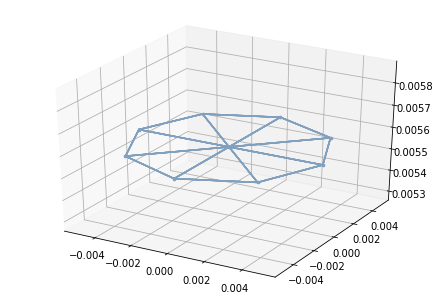

In [16]:
# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if (v.x_a[2] == -r):
            continue 
        else:
            del_list.append(v)      
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2] + r]
    #f_k = r*(np.array(f_k) - v_o)
    HC.V.move(v, tuple(f_k))
    
# Move film up to the h_0
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + h_0]
    HC.V.move(v, tuple(f_k))        

# Find origin and set of boundary vertices
bV = set()
for v in HC.V:
    if np.all(v.x_a[0:2] == 0.0):
        v_o = v  # origin vertex
        continue
    else:
        bV.add(v)
        
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)


In [12]:
# Ensure the norm is correct
print(f'Norm test (all should be equal to r = {r}):')
for v in HC.V:
    print(f'v.x_a = {v.x_a}')
    #print(f'v in bHC_V: {v in bHC_V}')
    print(f'norm = {np.linalg.norm(v.x_a - HC.V[(0.0, 0.0, h_0)].x_a)}')
# Ensure that the boundary doesn't contain the origin
print(f'Boundary test:')
for v in bV:
    print(f'v.x_a = {v.x_a}')
    if np.linalg.norm(v.x_a - HC.V[(0.0, 0.0, h_0)].x_a) in bV:
        print(f'FAILURE: ORIGIN in bHC_V')
        
#HC.V.print_out()

Norm test (all should be equal to r = 0.005):
v.x_a = [-0.00353553 -0.00353553  0.00628599]
norm = 0.005
v.x_a = [ 0.00353553 -0.00353553  0.00628599]
norm = 0.005
v.x_a = [-0.00353553  0.00353553  0.00628599]
norm = 0.005
v.x_a = [0.00353553 0.00353553 0.00628599]
norm = 0.005
v.x_a = [ 0.         -0.005       0.00628599]
norm = 0.005
v.x_a = [0.         0.         0.00628599]
norm = 0.0
v.x_a = [-0.005       0.          0.00628599]
norm = 0.005
v.x_a = [0.005      0.         0.00628599]
norm = 0.005
v.x_a = [0.         0.005      0.00628599]
norm = 0.005
Boundary test:
v.x_a = [-0.005       0.          0.00628599]
v.x_a = [-0.00353553  0.00353553  0.00628599]
v.x_a = [ 0.00353553 -0.00353553  0.00628599]
v.x_a = [0.         0.005      0.00628599]
v.x_a = [ 0.         -0.005       0.00628599]
v.x_a = [0.005      0.         0.00628599]
v.x_a = [-0.00353553 -0.00353553  0.00628599]
v.x_a = [0.00353553 0.00353553 0.00628599]


-
N_i[i] = [0. 0. 0.]
HN = [array([0., 0., 0.])]
df(H) = [[0. 0. 0.]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.          0.        -54.7090668]
df += rho g h = [[  0.          0.        -54.7090668]]
VA = [[0.         0.         0.00557687]]
f_k[i] = [0.         0.         0.00502978]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([ 0.        ,  0.        , 86.49891351])]
df(H) = [[0.        0.        6.2971209]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -49.34210734]
df += rho g h = [[  0.           0.         -43.04498644]]
VA = [[0.         0.         0.00502978]]
f_k[i] = [0.         0.         0.00459933]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 150.64819596])]
df(H) = [[ 0.          0.         10.96718867]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -45.11939417]
df += rho g h = [[  0.           0.         -34.15220551]]
VA = [[0.         0.         0.00459933]]
f_k[i] = [0.        0.        0.0042

-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 350.27060227])]
df(H) = [[ 0.          0.         25.49969984]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.74421066]
df += rho g h = [[ 0.          0.         -0.24451082]]
VA = [[0.         0.         0.00262428]]
f_k[i] = [0.         0.         0.00262184]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 350.41055338])]
df(H) = [[ 0.          0.         25.50988829]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.72022415]
df += rho g h = [[ 0.          0.         -0.21033586]]
VA = [[0.         0.         0.00262184]]
f_k[i] = [0.         0.         0.00261973]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 350.53074846])]
df(H) = [[ 0.          0.         25.51863849]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.          0.        -25.6995902]
df += rho g h = [[ 0.          0.         -0.18095171]]
VA = [[0.      

HN = [array([  0.        ,   0.        , 351.25998509])]
df(H) = [[ 0.          0.         25.57172691]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57373166]
df += rho g h = [[ 0.          0.         -0.00200475]]
VA = [[0.        0.        0.0026069]]
f_k[i] = [0.         0.         0.00260688]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26111935])]
df(H) = [[ 0.          0.         25.57180949]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.         0.       -25.573535]
df += rho g h = [[ 0.          0.         -0.00172551]]
VA = [[0.         0.         0.00260688]]
f_k[i] = [0.         0.         0.00260687]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.       ,   0.       , 351.2620956])]
df(H) = [[ 0.          0.         25.57188056]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57336572]
df += rho g h = [[ 0.          0.         -0.00148516]]
VA = [[0.         0.         0.00260687]]
f_k[i] 

HN = [array([  0.      ,   0.      , 351.268061])]
df(H) = [[ 0.          0.         25.57231484]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57233134]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.65021598e-05]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26807033])]
df(H) = [[ 0.          0.         25.57231552]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57232972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42036512e-05]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26807837])]
df(H) = [[ 0.          0.         25.57231611]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57232833]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.22252911e-05]]
VA = [[

N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812761])]
df(H) = [[ 0.          0.         25.57231969]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231979]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.00636242e-07]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812767])]
df(H) = [[ 0.          0.         25.57231969]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231978]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -8.66190923e-08]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812772])]
df(H) = [[ 0.         0.        25.5723197]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231977]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -9.62497637e-10]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -8.28411117e-10]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -7.13029635e-10]]
V

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.07007736e-11]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -9.20152843e-12]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -7.91189336e-12]]
V

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.0000000e+00  0.0000000e+00 -9.9475983e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -7.10542736e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -7.46069873e-14]]
VA =

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
V

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
V

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
V

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
V

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
V

HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
V

-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.0000000

N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e+00 -1.42108547e-14]]
VA = [[0.         0.         0.00260676]]
f_k[i] = [0.         0.         0.00260676]
-
N_i[i] = [ 0.  0. -1.]
HN = [array([  0.        ,   0.        , 351.26812802])]
df(H) = [[ 0.          0.         25.57231972]]
(rho * g * h) * np.array([0.0, 0.0, -1.0]) = [  0.           0.         -25.57231972]
df += rho g h = [[ 0.00000000e+00  0.00000000e

C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_complex.py:3751: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


The final capillary height rise is 0.002606760419989071 m
Expected rise: 0.002788433577789569


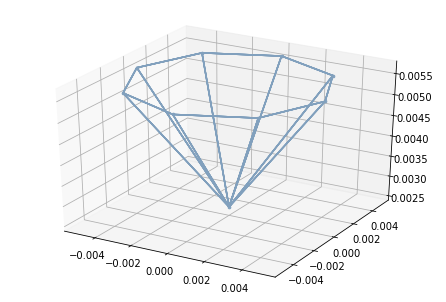

In [13]:
# Initiate a cubical complex
HC = Complex(3, domain=[(-r, r),]*3)
HC.triangulate()

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == -r) or np.any(v.x_a == r):
        if (v.x_a[2] == -r):
            continue 
        else:
            del_list.append(v)      
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

# Shrink to circle and move to zero
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [x * np.sqrt(r**2 - y**2/2.0)/r, y * np.sqrt(r**2 - x**2/2.0)/r, v.x_a[2] + r]
    #f_k = r*(np.array(f_k) - v_o)
    HC.V.move(v, tuple(f_k))
    
# Move up to twice the Jurin heigh
for v in HC.V:
    x = v.x_a[0]
    y = v.x_a[1]
    f_k = [v.x_a[0], v.x_a[1], v.x_a[2] + 2 * h_jurin]
    HC.V.move(v, tuple(f_k))        

# Find origin and set of boundary vertices
bV = set()
for v in HC.V:
    if np.all(v.x_a[0:2] == 0.0):
        v_o = v  # origin vertex
        continue
    else:
        bV.add(v)

if 0:  #TODO: Hack for scale; remove after correct equilibrium is found:
    fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                               line_color=db,
                                               complex_color_f=lb,
                                               complex_color_e=db
                                               )

h_0 = 2*h_jurin

for i in range(500):
    HC = mean_flow(HC, bV, h_0=h_0, tau=1e-5)
 
#Find the equilibrium capillary rise:
h_f = 2 *h_jurin
for v in HC.V:
    if v in bV:
        continue
    else:    
        h_f = min(v.x[2], h_f)
        
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )
#axes.set_xlim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_ylim3d(-(0.1*r + r) , 0.1*r + r)
#axes.set_zlim3d(-(0.1*r + r) , 0.1*r + 2*r)

print(f'The final capillary height rise is {h_f} m')
print(f'Expected rise: {h_jurin}')

In [14]:
for v in HC.V:
    print(v.x)

(-0.0035355339059327377, -0.0035355339059327377, 0.005576867155579138)
(0.0035355339059327377, -0.0035355339059327377, 0.005576867155579138)
(-0.0035355339059327377, 0.0035355339059327377, 0.005576867155579138)
(0.0035355339059327377, 0.0035355339059327377, 0.005576867155579138)
(0.0, -0.005, 0.005576867155579138)
(-0.005, 0.0, 0.005576867155579138)
(0.005, 0.0, 0.005576867155579138)
(0.0, 0.005, 0.005576867155579138)
(0.0, 0.0, 0.002606760419989071)


In [15]:
6*((0.002788433577789569 - 0.00260676041998907) / 0.002788433577789569)

0.3909144386602472

In [17]:
100*((0.002788433577789569 - 0.00260676041998907) / 0.002788433577789569)

6.515240644337454